<a href="https://colab.research.google.com/github/SUBHAMSSK/MLTASK/blob/main/task__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q langgraph langchain langchain-google-genai google-generativeai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.2 MB/s eta 0:00:00


In [20]:
import os
from getpass import getpass
os.environ["GOOGLE_API_KEY"] = getpass("🔐 Enter your Google API Key: ")
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.3
)
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from typing import TypedDict
from langchain_core.tools import tool

class GraphState(TypedDict):
    input : str
    output : str

@tool
def calculator_tool(expression: str) -> str:
    """Evaluate a basic arithmetic expression like 2+3 or (4*5)-2."""
    try:
        allowed_chars = "1234567890*+/-() "
        if all(ch in allowed_chars for ch in expression):
            expression = expression.replace(" ", "")
            return f"The value of the expression is {eval(expression)}"
        else:
            return llm.invoke(expression).content
    except Exception as e:
        return f"The error is: {e}"


def chatbot_node(state: GraphState) -> GraphState:
  user_input = state["input"]
  if any(operator in user_input for operator in "+-/*"):
    state["output"] = state["output"] + calculator_tool(user_input)
  else:
    state["output"] = state["output"] + llm.invoke(user_input).content
  return state

graph = StateGraph(GraphState)
graph.add_node("chatbot", RunnableLambda(chatbot_node))
graph.set_entry_point("chatbot")
graph.set_finish_point("chatbot")

executable_graph = graph.compile()



🔐 Enter your Google API Key: ··········


In [21]:
output = executable_graph.invoke({"input": "What is (69+56*2)-86)?","output":""})
print(output["output"])

<ipython-input-20-927e94782486>:36: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  state["output"] = state["output"] + calculator_tool(user_input)


Here's how to solve the equation step-by-step:

1. **Multiplication first:** 56 * 2 = 112

2. **Addition:** 69 + 112 = 181

3. **Subtraction:** 181 - 86 = 95

Therefore, the answer is $\boxed{95}$


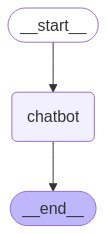

In [22]:
from IPython.display import Image, display
display(Image(executable_graph.get_graph().draw_mermaid_png()))

In [24]:
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [26]:
from langchain_core.tools import tool
import spacy

# Load spaCy model once globally for efficiency
nlp = spacy.load("en_core_web_lg")

# Ensure llm is defined (e.g., ChatGoogleGenerativeAI or ChatOpenAI)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")  # example setup

@tool("fashion_tool", parse_docstring=True)
def fashion_tool(input_text: str) -> str:
    """
    Answers fashion-related questions by providing trending clothing suggestions based on the location mentioned in the input.

    Args:
        input_text: A user question or message related to fashion, optionally mentioning a place (e.g., city or country).

    Returns:
        A short list of trending fashion suggestions relevant to the mentioned location, or a message if no location is found.
    """
    try:
        doc = nlp(input_text)
        for ent in doc.ents:
            if ent.label_ == "GPE":
                return llm.invoke(
                    f"Give 4-5 examples of trending clothes in {ent.text}. Keep it short and relevant to current fashion trends."
                ).content
        return "🌍 Please mention a location (city or country) to get fashion suggestions."
    except Exception as e:
        return f"⚠️ Error in fashion tool: {e}"


In [27]:
def main():
    print("Welcome to the Fashion Assistant!")
    print("Please ask a question about fashion, including a location (city or country).")

    # Get user input
    user_question = input("Your question: ")

    # Call the fashion_tool
    response = fashion_tool(user_question)

    # Print the tool's response
    print("\nFashion Assistant says:")
    print(response)

if __name__ == "__main__":
    main()


Welcome to the Fashion Assistant!
Please ask a question about fashion, including a location (city or country).
Your question: Milan fashion

Fashion Assistant says:
1. **Elevated basics:**  High-quality, minimalist knitwear and tailored trousers in neutral tones.
2. **Bold shoulders:**  Structured blazers and jackets with strong shoulder lines.
3. **Statement outerwear:**  Maximalist coats in vibrant colors or unique textures (e.g., shearling, faux fur).
4. **Leather everything:**  Leather pants, skirts, and jackets in various shades and finishes.
5. **Italian craftsmanship:**  Focus on luxurious fabrics and impeccable tailoring, regardless of specific style.


In [29]:
import requests
from getpass import getpass
from datetime import datetime
import spacy
from langchain_core.tools import tool

# Load spaCy model globally
nlp = spacy.load("en_core_web_lg")

# Ask user to securely enter their API key
API_KEY = getpass("🔐 Enter your OpenWeatherMap API Key: ")

@tool("weather_tool", parse_docstring=True)
def get_weather(input_text: str, API_KEY: str) -> str:
    """
    Answers weather-related questions by fetching current weather data based on the city mentioned.

    Args:
        input_text: A user question or message containing a city name.
        API_KEY: OpenWeatherMap API key.

    Returns:
        A weather summary for the mentioned city.
    """
    city_name = ""

    doc = nlp(input_text)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            city_name = ent.text
            break
    else:
        city_name = input_text  # fallback if no entity found

    url = f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&units=metric&appid={API_KEY}"
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or "main" not in data:
        return f"⚠️ Could not fetch weather data for '{city_name}'. Error: {data.get('message', 'Unknown error')}"

    temp = data["main"]["temp"]
    feels_like = data["main"]["feels_like"]
    humidity = data["main"]["humidity"]
    pressure = data["main"]["pressure"]
    wind_speed = data["wind"]["speed"]
    description = data["weather"][0]["description"].capitalize()
    clouds = data["clouds"]["all"]
    visibility = data.get("visibility", "Unknown")

    sunrise = datetime.utcfromtimestamp(data["sys"]["sunrise"]).strftime('%H:%M UTC')
    sunset = datetime.utcfromtimestamp(data["sys"]["sunset"]).strftime('%H:%M UTC')

    return (
        f"🌤️ Weather in {city_name}:\n"
        f"- Description: {description}\n"
        f"- Temperature: {temp}°C (Feels like: {feels_like}°C)\n"
        f"- Humidity: {humidity}%\n"
        f"- Pressure: {pressure} hPa\n"
        f"- Wind Speed: {wind_speed} m/s\n"
        f"- Cloud Cover: {clouds}%\n"
        f"- Visibility: {visibility} meters\n"
        f"- Sunrise: {sunrise} | Sunset: {sunset}"
    )

# Simple interactive CLI to use the weather tool
def main():
    print("🌦️ Welcome to the Weather Assistant!")
    print("Ask a question about the weather, including a city name.")

    user_question = input("Your question: ")
    result = get_weather.invoke({"input_text": user_question, "API_KEY": API_KEY})

    print("\nWeather Assistant says:")
    print(result)

if __name__ == "__main__":
    main()



🔐 Enter your OpenWeatherMap API Key: ··········
🌦️ Welcome to the Weather Assistant!
Ask a question about the weather, including a city name.
Your question: bhubaneswar 

Weather Assistant says:
⚠️ Could not fetch weather data for 'bhubaneswar '. Error: city not found


In [30]:


!pip install langgraph

In [32]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from typing import TypedDict

class MemoryState(TypedDict):
    User: list[str]
    Bot: list[str]

class GraphState(TypedDict):
    input : str
    output : str


from getpass import getpass

# Global configuration dict to store persistent data
CONFIG = {
    "API_KEY": None
}

def chatbot_node(state: GraphState) -> GraphState:
    user_input = state["input"]

    if any(operator in user_input for operator in "+-/*"):
        state["output"] += calculator_tool(user_input)

    elif any(word in user_input.lower() for word in ["weather", "climate", "temperature", "humidity", "rainfall", "wind", "sunrise", "sunset"]):
        if CONFIG["API_KEY"] is None:
            CONFIG["API_KEY"] = getpass("🔐 Enter your OpenWeatherMap API Key: ")
        state["output"] += get_weather.invoke({
            "input_text": user_input,
            "API_KEY": CONFIG["API_KEY"]
        })

    elif any(word in user_input.lower() for word in ["fashion", "trends","trend", "clothing", "clothes", "wear","trending"]):
        state["output"] += fashion_tool(user_input)

    else:
        state["output"] += "Please ask something regarding calculating, weather, or fashion trends — one domain at a time."

    return state
Memory = {
    "User" : [],
    "Bot" : [],
}
print("Bot : You may ask something regardin Calculating or weather or fashion trends and at a time only one domain. Please enter exit if you want to end the conversation")
Memory["Bot"].append("Bot : You may ask something regardin Calculating or weather or fashion trends and at a time only one domain. Please enter exit if you want to end the conversation")
while True:
  user_input = input("User : ")
  if user_input.lower() == "exit":
    break
  Memory["User"].append(user_input)
  graph = StateGraph(GraphState)
  graph.add_node("chatbot", RunnableLambda(chatbot_node))
  graph.set_entry_point("chatbot")
  graph.set_finish_point("chatbot")
  executable_graph = graph.compile()
  output = executable_graph.invoke({"input": user_input,"output":""})
  Memory["Bot"].append(output["output"])
  print("Bot : ",output["output"])


Bot : You may ask something regardin Calculating or weather or fashion trends and at a time only one domain. Please enter exit if you want to end the conversation
User : Milan weather
🔐 Enter your OpenWeatherMap API Key: ··········
Bot :  🌤️ Weather in Milan:
- Description: Clear sky
- Temperature: 20.86°C (Feels like: 20.18°C)
- Humidity: 45%
- Pressure: 1014 hPa
- Wind Speed: 2.57 m/s
- Cloud Cover: 0%
- Visibility: 10000 meters
- Sunrise: 03:43 UTC | Sunset: 18:56 UTC
User : Milan fashion
Bot :  1. **Elevated basics:**  High-quality, minimalist pieces in neutral tones like beige, cream, and grey, often featuring subtle detailing.
2. **Bold shoulders:**  Structured blazers and jackets with strong shoulder lines, adding a powerful silhouette.
3. **Statement outerwear:**  Oversized coats in vibrant colors or unique textures (like shearling or bouclé).
4. **Tailored trousers:**  Wide-leg or straight-leg trousers in luxurious fabrics like wool or silk, often paired with fitted tops.
5. *